# **NLP Project**

In [1]:
import os
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import sys
sys.path.append("src")
from data_loading import *
from prompt_utils import *
import re
from tqdm.notebook import tqdm

torch.cuda.is_available()

True

### Dataset downloading

In [2]:
DATASET_PATH = "dataset"

if not os.path.isdir(DATASET_PATH):
    !wget -nc -P . https://allenai.org/data/proofwriter
    !unzip -q -d . proofwriter
    !mv proofwriter-dataset-V2020.12.3 $DATASET_PATH
    !rm proofwriter

### Dataset loading

In [3]:
dataset = ProofWriterDataset(None, DATASET_PATH + "/OWA/depth-3/meta-train.jsonl", triple_label="t", rule_label="r")
examples_dataset = ProofWriterDataset(None, DATASET_PATH + "/OWA/depth-3/meta-dev.jsonl", triple_label="t", rule_label="r")

In [4]:
examples = [examples_dataset[12]] #[(i, e) for i, e in enumerate(examples_dataset) if i < 20]
examples

[{'context': 't1: The bear is kind. t2: The bear is young. t3: The mouse is red. r1: If the mouse likes the bear then the bear likes the mouse. r2: If something likes the bear then the bear visits the mouse. r3: If something is young then it likes the bear. r4: If something is red then it sees the bear. r5: If something visits the mouse then the mouse visits the bear. r6: If something is kind and it visits the bear then the bear is young. ',
  'question': 'The bear visits the mouse.',
  'label': 'True',
  'proof': '((((t2) -> (r3 % int2))) -> (r2 % int1)) ; with int1 = The bear visits the mouse.int2 = The bear likes the bear.'}]

### Model loading

In [5]:
torch.random.manual_seed(0)

model_name = "mistralai/Mistral-7B-Instruct-v0.3" # "microsoft/Phi-4-mini-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    # torch_dtype="auto",
    trust_remote_code=True,
    attn_implementation="eager"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = "eos_token_id"
 
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    batch_size=1,
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


### Execution

In [24]:
def str_bool_to_bin(b):
    if b not in ["True", "False"]: raise Exception(f"The input must be True of False; '{b}' received.")
    return int(b == "True")

y_true = []

N_PROMPTS = 100
prompts = []

for i, e in enumerate(dataset):
    if i >= N_PROMPTS: break
    y_true.append(str_bool_to_bin(e["label"]))
    # print(e["question"])
    # print(e["proof"])
    prompts.append(build_one_shot_prompt(e, examples, proof=True))

In [25]:
"""tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id
encoded = tokenizer([p[0] for p in prompts], return_offsets_mapping=True, return_tensors="pt", padding=True).to("cuda")
offset_mapping = encoded.pop("offset_mapping")

generation_args = {
    "output_attentions" : True,
    "return_dict_in_generate": True,
    "max_new_tokens": 30,
    "do_sample": False
}

with torch.no_grad():
    outputs = model.generate(**encoded, **generation_args)"""
pass

In [26]:
y_pred = []
mean_attention_per_group_last_layer = None

generation_args = {
    "output_attentions" : True,
    "return_dict_in_generate": True,
    "max_new_tokens": 50,
    "do_sample": False,
    "pad_token_id": tokenizer.eos_token_id
}

for i, (prompt, prompt_segmentation, theory_segmentation) in tqdm(enumerate(prompts), total=len(prompts)):

    encoded = tokenizer(
        prompt,
        return_offsets_mapping=True,
        return_tensors="pt",
        padding=True
    )

    offset_mapping = encoded.pop("offset_mapping")
    encoded = encoded.to("cuda")

    with torch.no_grad():
        outputs = model.generate(**encoded, **generation_args)


    ###########################

    if not mean_attention_per_group_last_layer:
        mean_attention_per_group_last_layer = [[] for _ in range(len(prompt_segmentation))]
    
    # print(prompt)
    # print("----")
    generated_text = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)[len(prompt):]
    #print(generated_text)

    tag = "final"
    reg_str = "<" + tag + ">(.*?)</" + tag + ">"
    res = re.findall(reg_str, generated_text)[0]

    y_pred.append(str_bool_to_bin(res))

    input_ids = encoded["input_ids"]
    offsets = offset_mapping[0]
    groups_delimiters_by_characters = reduce(lambda acc, x : acc + [x[1]], prompt_segmentation.values(), [0])
    groups_intervals_by_token = get_groups_delimiter_intervals_by_tokens(groups_delimiters_by_characters, offsets)
    n_input_tokens = groups_intervals_by_token[-1][-1]

    # print([layer[i].detach().to(torch.float32).cpu().numpy() for layer in outputs.attentions])

    prompt_length = encoded["input_ids"].shape[-1]
    new_token_ids = outputs.sequences[0][prompt_length:]
    tokens = tokenizer.convert_ids_to_tokens(new_token_ids)
    non_special_tokens = [t for t in tokens if not tokenizer.special_tokens_map.get(t) and t not in tokenizer.all_special_tokens]
    # print(f"Non special tokens generated: {len(non_special_tokens)}")

    means = np.zeros(n_input_tokens)
    means2 = []
    
    for k, attn_gen_token in enumerate(outputs.attentions):
        if k == 0: continue # attention map only referred to input tokens
        if k == len(non_special_tokens)+1: break

        """for l, layer in enumerate(attn_gen_token):
            for head in layer[i].detach().to(torch.float32).cpu().numpy():
                means += head[0][:n_input_tokens]
            means[l] /= k"""
        

        # means2.append(np.mean([np.mean([head[0][:n_input_tokens] for head in layer[i].detach().to(torch.float32).cpu().numpy()], axis=0) for layer in attn_gen_token], axis=0))
        means2.append(np.mean([head[0][:n_input_tokens] for head in attn_gen_token[-1][0].detach().to(torch.float32).cpu().numpy()], axis=0))
    

    #attentions = [token for token in outputs.attentions] # extracting prompt attention
    #layers = [l[i].detach().to(torch.float32).cpu().numpy() for l in attentions]

    mean_output_attention = np.mean(means2, axis=0)

    # mean_output_attention = np.mean([np.mean([head[n_input_tokens:][:n_input_tokens].sum(axis=0) for head in layer], axis=0) for layer in layers], axis=0)

    groups_mean_attention = np.zeros((1, len(prompt_segmentation)))

    for j, (start, end) in enumerate(groups_intervals_by_token):
        values = mean_output_attention[start:end]
        groups_mean_attention[0][j] = np.mean(values)

    [l.append(groups_mean_attention[0][j]) for j, l in enumerate(mean_attention_per_group_last_layer)]

    # 
    theory_intervals_by_token = get_groups_delimiter_intervals_by_tokens(theory_segmentation, offsets)
    mean_attention_on_theory_components = np.zeros((1, len(theory_intervals_by_token)))
    
    for j, (start, end) in enumerate(theory_intervals_by_token):
        values = mean_output_attention[start:end]
        mean_attention_on_theory_components[0][j] = np.mean(values)
    
    
    """plt.figure(figsize=(20, 1))
    hm = sns.heatmap(groups_mean_attention, xticklabels=list(prompt_segmentation.keys()), yticklabels=["output"], cmap="summer", annot=True)
    hm.set_xticklabels(hm.get_xticklabels(), rotation=30, ha="right")
    plt.title("Mean attention from output tokens to input groups of tokens")
    plt.xticks(rotation=30)
    plt.show()

    plt.figure(figsize=(20, 1))
    hm = sns.heatmap(mean_attention_on_theory_components, xticklabels=list([prompt[theory_segmentation[i] : theory_segmentation[i+1]] for i in range(len(theory_segmentation)-1)]), yticklabels=["output"], cmap="summer", annot=True)
    hm.set_xticklabels(hm.get_xticklabels(), rotation=30, ha="right")
    plt.title("Mean attention from output tokens to groups of tokens of the theory")
    plt.show()"""
    
    ######################

    del outputs, encoded
    torch.cuda.empty_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
assert len(y_true) == len(y_pred), f"{len(y_true)} != {len(y_pred)}"
def print_metric(name, value): print(f"{name:>10}: {value:.3}")
print_metric("accuracy", accuracy_score(y_true, y_pred))
print_metric("f1 score", f1_score(y_true, y_pred))
print_metric("prec", precision_score(y_true, y_pred))
print_metric("rec", recall_score(y_true, y_pred))
print("\npos ground truth:", sum(y_true))
print("neg ground truth:", len(y_true) - sum(y_true))

  accuracy: 0.61
  f1 score: 0.381
      prec: 0.923
       rec: 0.24

pos ground truth: 50
neg ground truth: 50


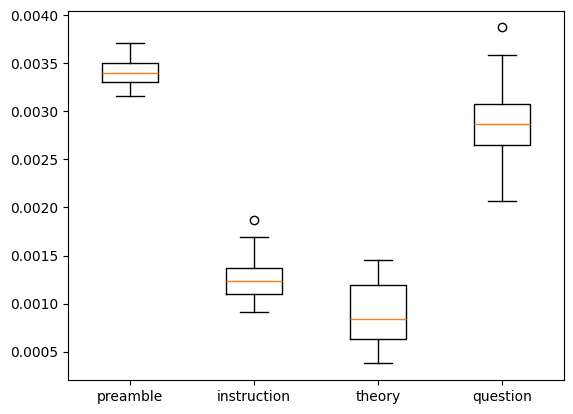

In [41]:
plt.boxplot(mean_attention_per_group_last_layer, tick_labels=prompt_segmentation.keys())
plt.show()